<a href="https://colab.research.google.com/github/adityabaidya7/INFY_StockPricePrediction/blob/main/LSTM_Without_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import datetime
from datetime import date
import holidays
from sklearn.metrics import mean_absolute_error

/tmp/ipython-input-8-3693164947.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1201
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0033
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0020
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0016
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0016
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0015
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0014
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0013
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0014
Enter the date for prediction (YYYY-MM-DD): 2025-05-26


/tmp/ipython-input-8-3693164947.py:90: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


/tmp/ipython-input-8-3693164947.py:111: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Predicted closing price for 2025-05-26: 1581.35
Error retrieving actual price: unsupported format string passed to Series.__format__


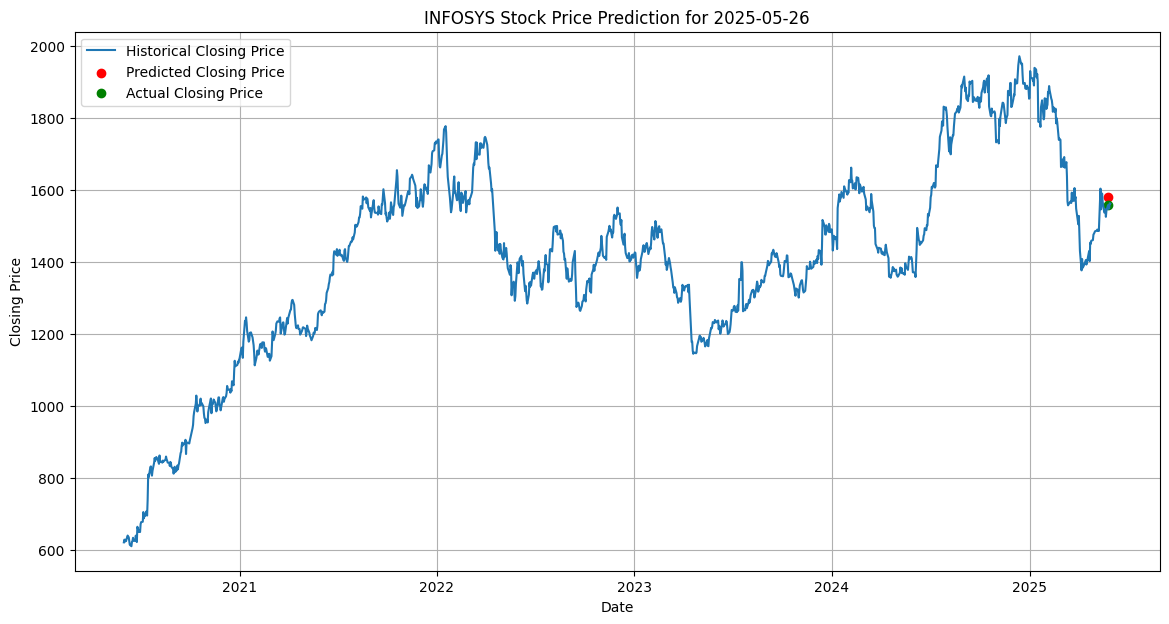

In [ ]:
# Define the date range for training data
start_date = '2020-06-01'
end_date = '2025-05-31'

# Define the stock ticker
ticker = 'INFY.NS'  # NSE: INFY

# Download historical data
try:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

if stock_data.empty:
    print("No data downloaded. Check ticker and date range.")
    exit()

# Use only the 'Close' price for prediction
data = stock_data['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60  # Number of previous days to consider
X_train, y_train = create_sequences(scaled_data, sequence_length)

# Reshape data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose = 1)

# Function to validate user input date
def validate_date(date_str):
    try:
        user_date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        today = date.today()

        # Check if the date is within the valid range
        min_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
        max_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
        if not (min_date <= user_date <= max_date):
            print("Error: Date must be within the range 2020-06-01 to 2025-05-31.")
            return None

        # Check if it's a weekday
        if user_date.weekday() > 4:  # Monday is 0, Sunday is 6
            print("Error: Please enter a weekday.")
            return None

        # Check for Indian trading holidays
        in_holidays = holidays.India()
        if user_date in in_holidays:
            print(f"Error: {user_date} is a trading holiday in India.")
            return None

        return user_date
    except ValueError:
        print("Error: Invalid date format. Please use YYYY-MM-DD.")
        return None

# Get user input date
user_date_str = input("Enter the date for prediction (YYYY-MM-DD): ")
prediction_date = validate_date(user_date_str)

if prediction_date:
    # Prepare data for prediction
    # We need the last 'sequence_length' days of data up to the day before the prediction date
    try:
        prediction_end_date = prediction_date - datetime.timedelta(days=1)
        prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
    except Exception as e:
        print(f"Error downloading data for prediction: {e}")
        exit()

    if prediction_data.empty or len(prediction_data) < sequence_length:
        print("Insufficient data to make a prediction.")
        exit()

    last_sequence = prediction_data['Close'].values[-sequence_length:].reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    X_predict = np.reshape(last_sequence_scaled, (1, sequence_length, 1))

    # Predict the closing price
    predicted_price_scaled = model.predict(X_predict)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    print(f"\nPredicted closing price for {prediction_date}: {predicted_price[0][0]:.2f}")

    # Get the actual closing price if available
    try:
        actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
        if not actual_data.empty:
            actual_price = actual_data['Close'].iloc[0]
            print(f"Actual closing price for {prediction_date}: {actual_price:.2f}")

            # Calculate and print accuracy
            mae = mean_absolute_error([actual_price], [predicted_price[0][0]])
            print(f"Mean Absolute Error (MAE) for the prediction: {mae:.2f}")

        else:
            print(f"Actual closing price for {prediction_date} is not yet available.")
    except Exception as e:
        print(f"Error retrieving actual price: {e}")

    # Visualize the data and prediction
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index, stock_data['Close'], label='Historical Closing Price')
    plt.scatter(prediction_date, predicted_price[0][0], color='red', label='Predicted Closing Price')
    if not actual_data.empty:
        plt.scatter(prediction_date, actual_price, color='green', label='Actual Closing Price')
    plt.title(f'INFOSYS Stock Price Prediction for {prediction_date}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

/tmp/ipython-input-1-1510017998.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0956
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0032
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0018
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0014
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0014
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0015
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0011
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0010
Enter the date for prediction (YYYY-MM-DD): 2025-05-14


/tmp/ipython-input-1-1510017998.py:107: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step

Predicted closing price for 2025-05-14: 1495.48


/tmp/ipython-input-1-1510017998.py:129: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Error retrieving actual price: unsupported format string passed to Series.__format__


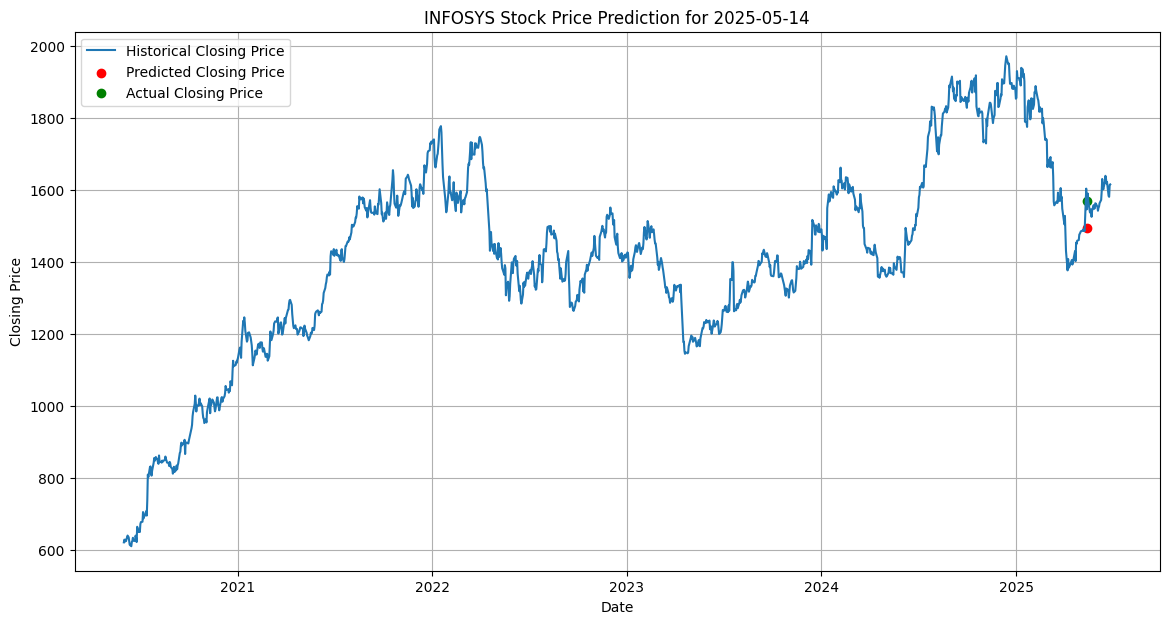

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
#!pip install nsepy yfinance scikit-learn tensorflow matplotlib holidays
# %%
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import datetime
from datetime import date
import holidays
from sklearn.metrics import mean_absolute_error # Import mean_absolute_error

# Define the date range for training data
start_date = '2020-06-01'
end_date = '2030-05-31'

# Define the stock ticker
ticker = 'INFY.NS'  # NSE: INFY

# Download historical data
try:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

if stock_data.empty:
    print("No data downloaded. Check ticker and date range.")
    exit()

# Use only the 'Close' price for prediction
data = stock_data['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60  # Number of previous days to consider
X_train, y_train = create_sequences(scaled_data, sequence_length)

# Reshape data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Function to validate user input date
def validate_date(date_str):
    try:
        user_date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        today = date.today()

        # Check if the date is within the valid range
        min_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
        max_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
        if not (min_date <= user_date <= max_date):
            print("Error: Date must be within the range 2020-06-01 to 2025-05-31.")
            return None

        # Check if it's a weekday
        if user_date.weekday() > 4:  # Monday is 0, Sunday is 6
            print("Error: Please enter a weekday.")
            return None

        # Check for Indian trading holidays
        in_holidays = holidays.India()
        if user_date in in_holidays:
            print(f"Error: {user_date} is a trading holiday in India.")
            return None

        return user_date
    except ValueError:
        print("Error: Invalid date format. Please use YYYY-MM-DD.")
        return None

# Get user input date
user_date_str = input("Enter the date for prediction (YYYY-MM-DD): ")
prediction_date = validate_date(user_date_str)

if prediction_date:
    # Prepare data for prediction
    # We need the last 'sequence_length' days of data up to the day before the prediction date
    try:
        prediction_end_date = prediction_date - datetime.timedelta(days=1)
        prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
    except Exception as e:
        print(f"Error downloading data for prediction: {e}")
        exit()

    # Add a check to ensure prediction_data has enough samples
    if prediction_data.empty or len(prediction_data) < sequence_length:
        print("Insufficient data to make a prediction.")
        exit()

    last_sequence = prediction_data['Close'].values[-sequence_length:].reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    X_predict = np.reshape(last_sequence_scaled, (1, sequence_length, 1))

    # Predict the closing price
    predicted_price_scaled = model.predict(X_predict)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    print(f"\nPredicted closing price for {prediction_date}: {predicted_price[0][0]:.2f}")

    # Get the actual closing price if available
    try:
        actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
        if not actual_data.empty:
            actual_price = actual_data['Close'].iloc[0]
            print(f"Actual closing price for {prediction_date}: {actual_price:.2f}")

            # Calculate and print accuracy (MAE)
            # We are comparing a single predicted value to a single actual value
            mae = mean_absolute_error([actual_price], [predicted_price[0][0]])
            print(f"Mean Absolute Error (MAE) for the prediction: {mae:.2f}")

        else:
            print(f"Actual closing price for {prediction_date} is not yet available.")
    except Exception as e:
        print(f"Error retrieving actual price: {e}")


    # Visualize the data and prediction
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index, stock_data['Close'], label='Historical Closing Price')
    plt.scatter(prediction_date, predicted_price[0][0], color='red', label='Predicted Closing Price')
    if 'actual_price' in locals(): # Only plot actual if it was retrieved
        plt.scatter(prediction_date, actual_price, color='green', label='Actual Closing Price')
    plt.title(f'INFOSYS Stock Price Prediction for {prediction_date}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_price, predicted_price)
r2 = r2_score(actual_price, predicted_price)
mape = mean_absolute_percentage_error(actual_price, predicted_price)

# Display the metrics
print("\nModel Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")



Model Evaluation on Test Data:
Mean Squared Error (MSE): 5598.9012
Root Mean Squared Error (RMSE): 74.8258
Mean Absolute Error (MAE): 74.8258
R² Score: nan
Mean Absolute Percentage Error (MAPE): 0.0477


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# **Plotting MSE over 10 epochs**

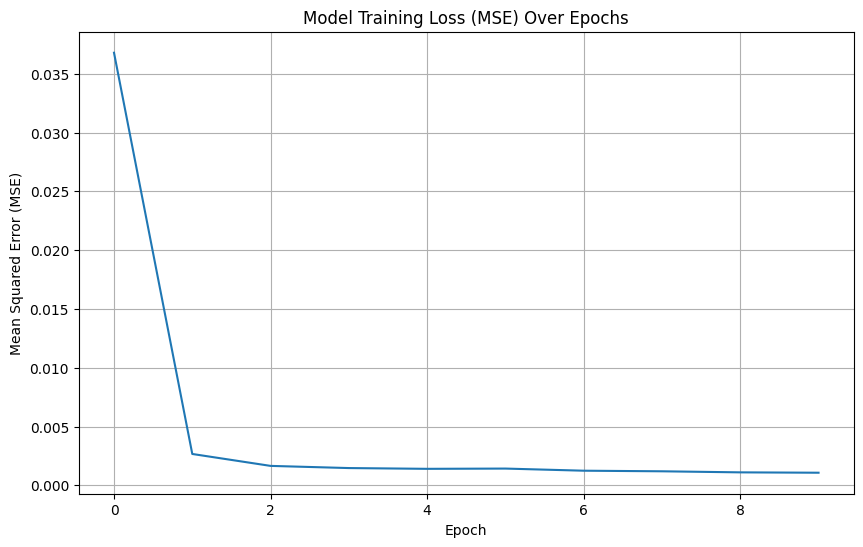

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss (MSE) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

# **LSTM model trained for 100 epochs**

/tmp/ipython-input-5-3018761961.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1791
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0045
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0020
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0016
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0015
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0015
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0015
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0013
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0012
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0013
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0011
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0010
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012
E

/tmp/ipython-input-5-3018761961.py:107: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


/tmp/ipython-input-5-3018761961.py:129: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


Predicted closing price for 2025-05-14: 1587.82
Error retrieving actual price: unsupported format string passed to Series.__format__


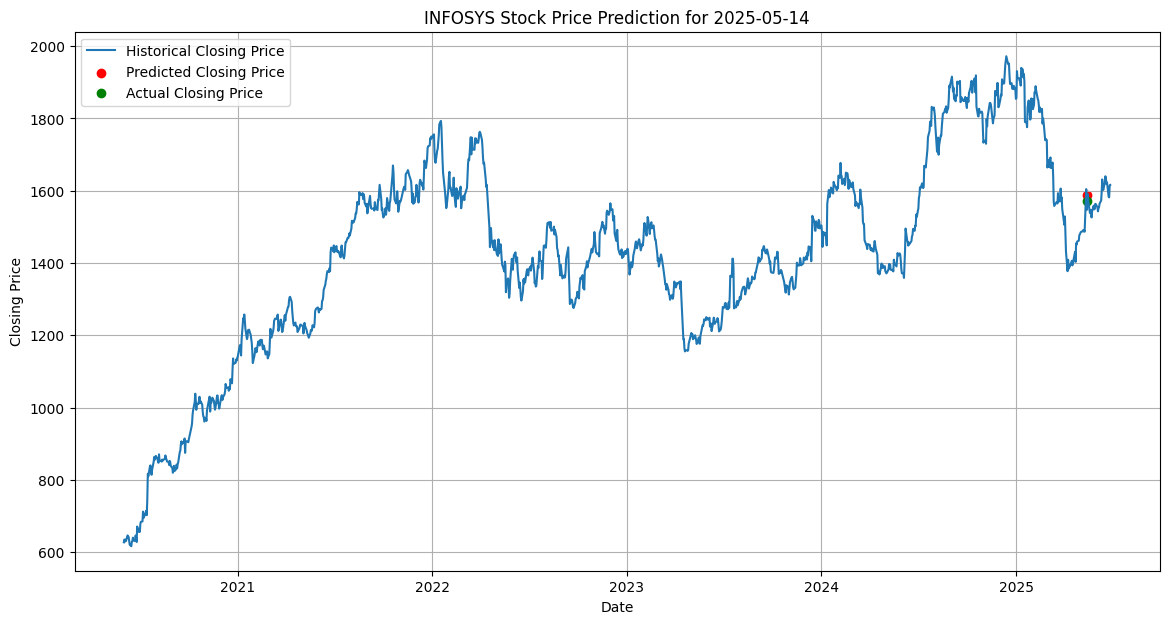

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
#!pip install nsepy yfinance scikit-learn tensorflow matplotlib holidays
# %%
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import datetime
from datetime import date
import holidays
from sklearn.metrics import mean_absolute_error # Import mean_absolute_error

# Define the date range for training data
start_date = '2020-06-01'
end_date = '2030-05-31'

# Define the stock ticker
ticker = 'INFY.NS'  # NSE: INFY

# Download historical data
try:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

if stock_data.empty:
    print("No data downloaded. Check ticker and date range.")
    exit()

# Use only the 'Close' price for prediction
data = stock_data['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60  # Number of previous days to consider
X_train, y_train = create_sequences(scaled_data, sequence_length)

# Reshape data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Function to validate user input date
def validate_date(date_str):
    try:
        user_date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        today = date.today()

        # Check if the date is within the valid range
        min_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
        max_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
        if not (min_date <= user_date <= max_date):
            print("Error: Date must be within the range 2020-06-01 to 2025-05-31.")
            return None

        # Check if it's a weekday
        if user_date.weekday() > 4:  # Monday is 0, Sunday is 6
            print("Error: Please enter a weekday.")
            return None

        # Check for Indian trading holidays
        in_holidays = holidays.India()
        if user_date in in_holidays:
            print(f"Error: {user_date} is a trading holiday in India.")
            return None

        return user_date
    except ValueError:
        print("Error: Invalid date format. Please use YYYY-MM-DD.")
        return None

# Get user input date
user_date_str = input("Enter the date for prediction (YYYY-MM-DD): ")
prediction_date = validate_date(user_date_str)

if prediction_date:
    # Prepare data for prediction
    # We need the last 'sequence_length' days of data up to the day before the prediction date
    try:
        prediction_end_date = prediction_date - datetime.timedelta(days=1)
        prediction_data = yf.download(ticker, start=start_date, end=prediction_end_date.strftime('%Y-%m-%d'))
    except Exception as e:
        print(f"Error downloading data for prediction: {e}")
        exit()

    # Add a check to ensure prediction_data has enough samples
    if prediction_data.empty or len(prediction_data) < sequence_length:
        print("Insufficient data to make a prediction.")
        exit()

    last_sequence = prediction_data['Close'].values[-sequence_length:].reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    X_predict = np.reshape(last_sequence_scaled, (1, sequence_length, 1))

    # Predict the closing price
    predicted_price_scaled = model.predict(X_predict)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    print(f"\nPredicted closing price for {prediction_date}: {predicted_price[0][0]:.2f}")

    # Get the actual closing price if available
    try:
        actual_data = yf.download(ticker, start=prediction_date.strftime('%Y-%m-%d'), end=(prediction_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
        if not actual_data.empty:
            actual_price = actual_data['Close'].iloc[0]
            print(f"Actual closing price for {prediction_date}: {actual_price:.2f}")

            # Calculate and print accuracy (MAE)
            # We are comparing a single predicted value to a single actual value
            mae = mean_absolute_error([actual_price], [predicted_price[0][0]])
            print(f"Mean Absolute Error (MAE) for the prediction: {mae:.2f}")

        else:
            print(f"Actual closing price for {prediction_date} is not yet available.")
    except Exception as e:
        print(f"Error retrieving actual price: {e}")


    # Visualize the data and prediction
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index, stock_data['Close'], label='Historical Closing Price')
    plt.scatter(prediction_date, predicted_price[0][0], color='red', label='Predicted Closing Price')
    if 'actual_price' in locals(): # Only plot actual if it was retrieved
        plt.scatter(prediction_date, actual_price, color='green', label='Actual Closing Price')
    plt.title(f'INFOSYS Stock Price Prediction for {prediction_date}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# **Performance metrics**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Calculate evaluation metrics
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_price, predicted_price)
#r2 = r2_score(actual_price, predicted_price)
mape = mean_absolute_percentage_error(actual_price, predicted_price)

# Display the metrics
print("\nModel Evaluation on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
#print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")



Model Evaluation on Test Data:
Mean Squared Error (MSE): 306.7672
Root Mean Squared Error (RMSE): 17.5148
Mean Absolute Error (MAE): 17.5148
Mean Absolute Percentage Error (MAPE): 0.0112


# **Plotting MSE over 100 epochs**

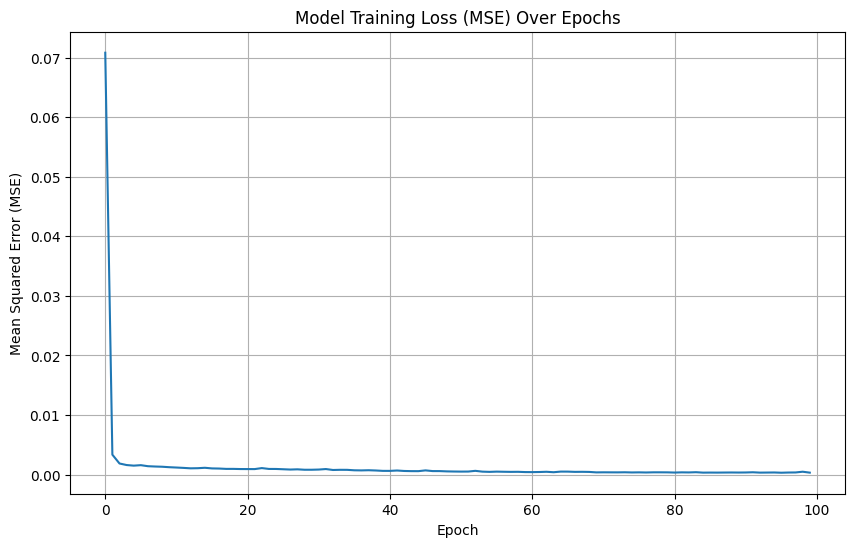

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Training Loss (MSE) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()